In [1]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2L

2024-02-10 15:51:13.224972: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-10 15:51:13.243522: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 15:51:13.243541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 15:51:13.244002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 15:51:13.247086: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Cell 2: Define constants
BATCH_SIZE = 64
IMG_HEIGHT = 480   #efficientnetv2L
IMG_WIDTH = 480
# IMG_HEIGHT = 300 #EfficientNetV2B3
# IMG_WIDTH = 300
# IMG_HEIGHT = 528 #EfficientNetB6
# IMG_WIDTH = 528
DATA_DIR = "/home/anon/MajorProject/Data/asl"

In [3]:
# Cell 3: Load data
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 25291 files belonging to 36 classes.
Using 20233 files for training.


2024-02-10 15:51:19.792592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 15:51:19.806321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 15:51:19.806352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 15:51:19.808396: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 15:51:19.808420: I external/local_xla/xla/stream_executor

Found 25291 files belonging to 36 classes.
Using 5058 files for validation.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(0.4),
        layers.RandomWidth(0.2),
        # layers.RandomTranslation(0.2, 0.2),
        layers.RandomCrop(IMG_HEIGHT, IMG_WIDTH)
    ]
)

In [5]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
# train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
# val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))


#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [6]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetV2L(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.3
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)  # Removed L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

2024-02-10 15:51:34.930094: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-10 15:51:34.930282: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-10 15:51:34.930387: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-10 15:51:34.930679: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-10 15:51:34.936337: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-10

In [7]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your model
plot_model(model, to_file='/home/anon/MajorProject/model.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [10]:
print(model.summary())

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 480, 480, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 480, 480, 3)          0         ['input_2[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 240, 240, 32)         864       ['rescaling_1[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 240, 240, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                    

In [8]:
# Cell 7: Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# checkpoint_filepath = '..\Checkpoints/Dataset_alpha/checkpoint-{epoch:02d}-{val_accuracy:.4f}.keras'
# model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [9]:
#Cell 8 train the model
epochs = 30
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/30


2024-02-10 15:52:17.964028: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-10 15:52:18.311461: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-02-10 15:52:19.029854: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-10 15:52:19.680053: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-10 15:52:19.680117: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilatio

  1/317 [..............................] - ETA: 2:00:44 - loss: 4.9368 - accuracy: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.1406

2024-02-10 15:52:22.971271: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


317/317 [==============================] - 675s 2s/step - loss: 1.7697 - accuracy: 0.4691 - sparse_categorical_accuracy: 0.4691 - sparse_top_k_categorical_accuracy: 0.8243 - val_loss: 1.2001 - val_accuracy: 0.7054 - val_sparse_categorical_accuracy: 0.7054 - val_sparse_top_k_categorical_accuracy: 0.9692
Epoch 2/30
317/317 [==============================] - 648s 2s/step - loss: 0.9860 - accuracy: 0.6774 - sparse_categorical_accuracy: 0.6774 - sparse_top_k_categorical_accuracy: 0.9592 - val_loss: 0.5182 - val_accuracy: 0.8223 - val_sparse_categorical_accuracy: 0.8223 - val_sparse_top_k_categorical_accuracy: 0.9939
Epoch 3/30
317/317 [==============================] - 646s 2s/step - loss: 0.8147 - accuracy: 0.7321 - sparse_categorical_accuracy: 0.7321 - sparse_top_k_categorical_accuracy: 0.9728 - val_loss: 0.3875 - val_accuracy: 0.8713 - val_sparse_categorical_accuracy: 0.8713 - val_sparse_top_k_categorical_accuracy: 0.9970
Epoch 4/30
317/317 [==============================] - 648s 2s/step

In [11]:
# Cell 10: Save the model
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2L_FEB_9.keras')
# model.save('/content/drive/MyDrive/Colab Notebooks/EfficientNetB6_without_onehot.keras')

In [12]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 [==============================] - 1s 427ms/step


2024-02-10 19:24:08.012238: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 88473600 bytes after encountering the first element of size 88473600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 [==============================] - 1s 427ms/step


2024-02-10 19:24:08.907615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 88473600 bytes after encountering the first element of size 88473600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 [==============================] - 1s 427ms/step


2024-02-10 19:24:09.805803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 88473600 bytes after encountering the first element of size 88473600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 [==============================] - 1s 428ms/step


2024-02-10 19:24:10.702924: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 88473600 bytes after encountering the first element of size 88473600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 4s 4s/step


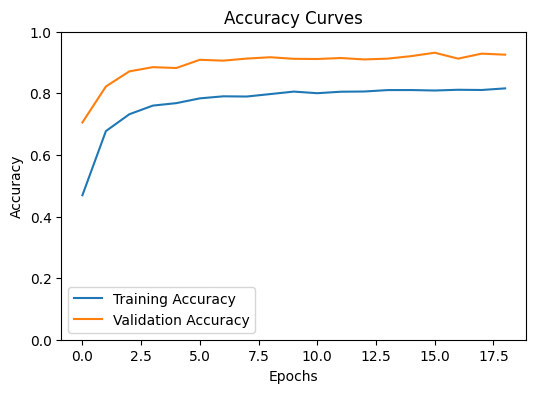

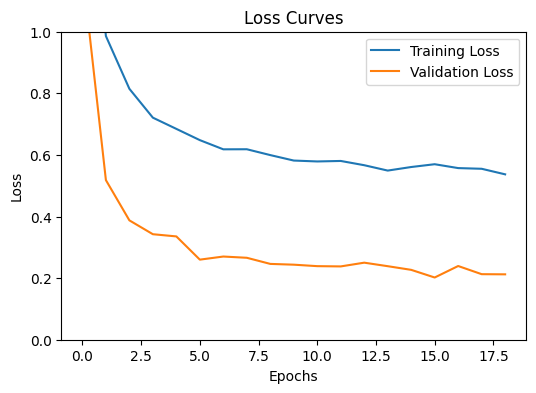

In [13]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


In [14]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 rescaling
2 stem_conv
3 stem_bn
4 stem_activation
5 block1a_project_conv
6 block1a_project_bn
7 block1a_project_activation
8 block1a_add
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block1c_project_conv
15 block1c_project_bn
16 block1c_project_activation
17 block1c_drop
18 block1c_add
19 block1d_project_conv
20 block1d_project_bn
21 block1d_project_activation
22 block1d_drop
23 block1d_add
24 block2a_expand_conv
25 block2a_expand_bn
26 block2a_expand_activation
27 block2a_project_conv
28 block2a_project_bn
29 block2b_expand_conv
30 block2b_expand_bn
31 block2b_expand_activation
32 block2b_project_conv
33 block2b_project_bn
34 block2b_drop
35 block2b_add
36 block2c_expand_conv
37 block2c_expand_bn
38 block2c_expand_activation
39 block2c_project_conv
40 block2c_project_bn
41 block2c_drop
42 block2c_add
43 block2d_expand_conv
44 block2d_expand_bn
45 block2d_expand_activation
46 block2d_project_conv
47 block2d_proj

In [15]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# we chose to train the top 2 blocks, i.e. we will freeze
# the first 668 layers and unfreeze the rest:
for layer in model.layers[:1029]:
   layer.trainable = False
for layer in model.layers[1029:]:
   layer.trainable = True
# we need to recompile the model for these modifications to take effect
# we train our model again (this time fine-tuning the top 2 blocks
# alongside the top Dense layers
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

epochs = 5
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/5


2024-02-10 19:25:34.368381: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-10 19:25:35.492989: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


317/317 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.8156 - sparse_categorical_accuracy: 0.8156 - sparse_top_k_categorical_accuracy: 0.9893

2024-02-10 19:35:24.841421: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


317/317 [==============================] - 676s 2s/step - loss: 0.5405 - accuracy: 0.8156 - sparse_categorical_accuracy: 0.8156 - sparse_top_k_categorical_accuracy: 0.9893 - val_loss: 0.1914 - val_accuracy: 0.9367 - val_sparse_categorical_accuracy: 0.9367 - val_sparse_top_k_categorical_accuracy: 0.9998
Epoch 2/5


2024-02-10 19:36:34.028617: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-10 19:36:35.046318: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


317/317 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.8185 - sparse_categorical_accuracy: 0.8185 - sparse_top_k_categorical_accuracy: 0.9885

2024-02-10 19:46:16.966699: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


317/317 [==============================] - 650s 2s/step - loss: 0.5343 - accuracy: 0.8185 - sparse_categorical_accuracy: 0.8185 - sparse_top_k_categorical_accuracy: 0.9885 - val_loss: 0.1866 - val_accuracy: 0.9353 - val_sparse_categorical_accuracy: 0.9353 - val_sparse_top_k_categorical_accuracy: 0.9998
Epoch 3/5


2024-02-10 19:47:24.276218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-10 19:47:25.264719: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


317/317 [==============================] - ETA: 0s - loss: 0.5153 - accuracy: 0.8245 - sparse_categorical_accuracy: 0.8245 - sparse_top_k_categorical_accuracy: 0.9906

2024-02-10 19:57:04.383318: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


317/317 [==============================] - 647s 2s/step - loss: 0.5153 - accuracy: 0.8245 - sparse_categorical_accuracy: 0.8245 - sparse_top_k_categorical_accuracy: 0.9906 - val_loss: 0.1843 - val_accuracy: 0.9357 - val_sparse_categorical_accuracy: 0.9357 - val_sparse_top_k_categorical_accuracy: 0.9998
Epoch 4/5


2024-02-10 19:58:11.725319: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-10 19:58:12.719862: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


317/317 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.8260 - sparse_categorical_accuracy: 0.8260 - sparse_top_k_categorical_accuracy: 0.9905

2024-02-10 20:07:55.092810: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


317/317 [==============================] - 651s 2s/step - loss: 0.5118 - accuracy: 0.8260 - sparse_categorical_accuracy: 0.8260 - sparse_top_k_categorical_accuracy: 0.9905 - val_loss: 0.1824 - val_accuracy: 0.9371 - val_sparse_categorical_accuracy: 0.9371 - val_sparse_top_k_categorical_accuracy: 0.9998
Epoch 5/5


2024-02-10 20:09:02.457586: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-10 20:09:03.462022: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


317/317 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.8246 - sparse_categorical_accuracy: 0.8246 - sparse_top_k_categorical_accuracy: 0.9904

2024-02-10 20:18:45.439913: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


317/317 [==============================] - 650s 2s/step - loss: 0.5136 - accuracy: 0.8246 - sparse_categorical_accuracy: 0.8246 - sparse_top_k_categorical_accuracy: 0.9904 - val_loss: 0.1797 - val_accuracy: 0.9383 - val_sparse_categorical_accuracy: 0.9383 - val_sparse_top_k_categorical_accuracy: 0.9998


In [16]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2024-02-10 20:28:06.552565: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-10 20:28:10.427479: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 88473600 bytes after encountering the first element of size 88473600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 [==============================] - 5s 417ms/step


2024-02-10 20:28:11.660366: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 88473600 bytes after encountering the first element of size 88473600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 5s 5s/step


Accuracy: 0.9383155397390273
Precision: 0.9432313559795745
Recall: 0.9389526834382185
F1 Score: 0.9377180882519016
AUC-ROC: 0.9685949416471933


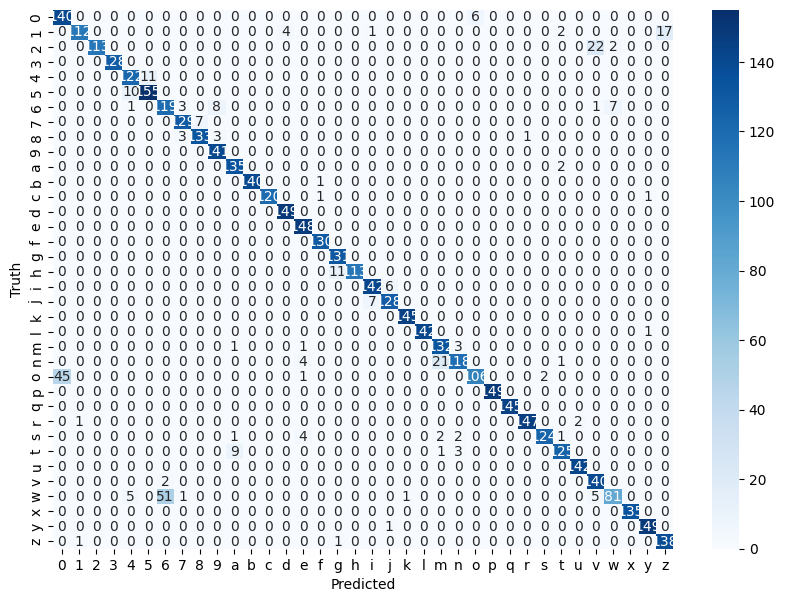

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score
average = 'macro'  # or 'micro', 'weighted', depending on the problem
precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)

# AUC-ROC for multiclass
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

# Assuming class_names is a list of your class names in the order they were encoded
# class_names = ["Brightness_Decrease", "Brightness_Increase", "Chrome_Open", "Cursor_Movement", "Double_Click", "Initiation", "Left_Click", "Neutral", "Nothing", "Right_Click", "Screenshot", "Scroll", "Shutdown", "Volume_Decrease", "Volume_Increase"]
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.9685949416471933


In [20]:
# model.save('/content/drive/MyDrive/Colab Notebooks/EfficientNetB6_without_onehot_finetuned.h5')
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2L_FEB_9_finetuned.keras')

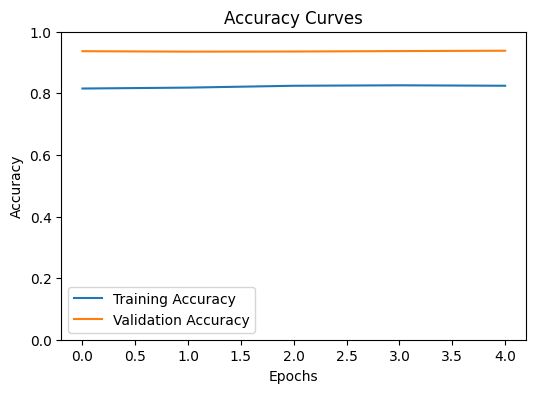

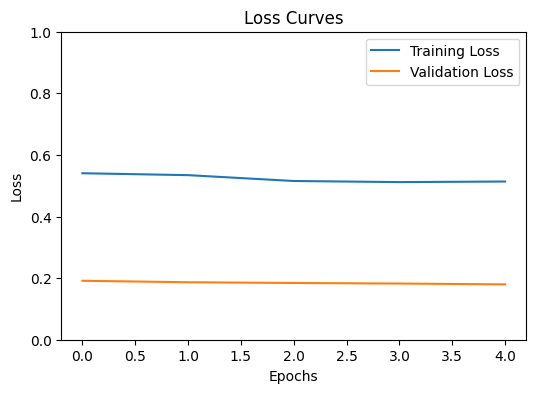

In [21]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
